In [22]:
## Импорт бибилиотек

In [1]:
import torch
import numpy as np
import pandas as pd
import sklearn
import multiprocessing as mp
from scipy.signal import spectrogram
from biosppy.signals.ecg import hamilton_segmenter
from biosppy.signals.ecg import correct_rpeaks
import scipy
from sklearn.datasets import make_regression
from torch.utils.data import Dataset
from tqdm import tqdm
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import StepLR
from pytorch.model import CNN_LSTM_matrix_input
from pytorch.model import SpectrogramNetwork, ResSpectrogramNetwork
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import StepLR
from DataLoader import load_df, save_df
from DataLoader import split_long_signals
from itertools import repeat
from pytorch.data import MyDataset
from tqdm import tqdm_pandas
from matplotlib import pyplot as plt
import multiprocessing as mp

/home/a.gurianov/signals_venv/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
## Описание датасета

In [5]:
tb_info = pd.read_csv("tb_info_new.csv", sep=";")
tb_info.rename(columns={"disease_info": "di", "patient_id":"p_id"}, inplace=True)

In [6]:
train = load_df("train_tb_r")
test = load_df("test_tb_r")
val = load_df("val_tb_r")

In [7]:
tb_info.rename(columns={"disease_info": "di", "patient_id":"p_id"}, inplace=True)

In [8]:
train_new = train.merge(tb_info, how="inner", on="cardiogram_id")

test_new = test.merge(tb_info, how="inner", on="cardiogram_id")

val_new = val.merge(tb_info, how="inner", on="cardiogram_id")

In [9]:
from pyecg import Signal
from pyecg import ECGRecord

In [10]:
from pyecg.annotations import ECGAnnotation


In [11]:
train_new.shape

(2711, 19)

In [12]:
test_new.shape

(1053, 19)

In [13]:
val_new.shape

(1081, 19)

In [43]:
tb_info.di.value_counts()

False    5283
True     1237
Name: di, dtype: int64

In [36]:
?Signal

Init signature: Signal(signal, lead_name)
Docstring:      <no docstring>
File:           ~/signals_venv/lib/python3.7/site-packages/pyecg/sequence_data.py
Type:           type
Subclasses:     


In [ ]:
train_new

In [20]:
def p_score(p_ids, answ, out):
    df = pd.DataFrame(data= {"ID": p_ids, "A": answ, "OUT": out})
    df["c"] = df["A"] == df["OUT"]
    return df.groupby("ID").c.mean().mean()

In [17]:
73 / (199 + 73)

0.26838235294117646

In [18]:
29 / (77 + 29)

0.27358490566037735

In [19]:
34 / (92 + 34)

0.2698412698412698

In [14]:
train_new.groupby('disease_info').patient_id.nunique()

disease_info
False    199
True      73
Name: patient_id, dtype: int64

In [15]:
val_new.groupby('disease_info').patient_id.nunique()

disease_info
False    77
True     29
Name: patient_id, dtype: int64

In [19]:
test_new.groupby('disease_info').patient_id.nunique()

disease_info
False    92
True     34
Name: patient_id, dtype: int64

In [10]:
print(train.shape)
print(train_new.shape)

(3046, 9)
(2711, 19)


In [15]:
print(val.shape)
print(val_new.shape)

(1109, 9)
(1081, 19)


In [16]:
print(test.shape)
print(test_new.shape)

(1122, 9)
(1053, 19)


In [92]:
import datetime

In [93]:
train_new["b_date"] = train_new["birthdate"].apply(lambda x: datetime.datetime.fromtimestamp(x))
train_new["c_date"] = train_new["ts"].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [94]:
def calculate_age(c_d, b_d):
    return c_d.year - b_d.year - ((c_d.month, c_d.day) < (b_d.month, b_d.day))

In [95]:
def get_age(df):
    df = df.copy()
    df["b_date"] = df["birthdate"].apply(lambda x: datetime.datetime.fromtimestamp(x))
    df["c_date"] = df["ts"].apply(lambda x: datetime.datetime.fromtimestamp(x))
    df["age"] = df[["c_date", "b_date"]].apply(lambda x: calculate_age(x[0], x[1]), axis=1)
    return df
train_new = get_age(train_new)
test_new = get_age(test_new)
val_new = get_age(val_new)

In [73]:
train_new.groupby(["disease_info"]).age.median()

disease_info
False    66
True     46
Name: age, dtype: int64

In [74]:
val_new.groupby(["disease_info"]).age.median()

disease_info
False    47
True     39
Name: age, dtype: int64

In [82]:
test_new.groupby(["disease_info"]).age.max()

disease_info
False    93
True     79
Name: age, dtype: int64

In [66]:
train_new.age.min()

19

In [53]:
train_new["b_date"]

0      1958-10-24 03:00:00
1      1973-08-09 03:00:00
2      1967-04-22 03:00:00
3      1963-05-28 03:00:00
4      1941-01-20 03:00:00
               ...        
2706   1984-01-03 03:00:00
2707   1982-03-31 03:00:00
2708   1982-03-31 03:00:00
2709   1982-03-31 03:00:00
2710   1976-02-18 03:00:00
Name: b_date, Length: 2711, dtype: datetime64[ns]

In [51]:
value = datetime.datetime.fromtimestamp(train_new["birthdate"][0])
print(value.strftime('%Y-%m-%d %H:%M:%S'))

1958-10-24 03:00:00


In [12]:
train_new.shape

(2711, 19)

In [47]:
train_new["birthdate"]

0      -353116800
1       113702400
2       -85104000
3      -208224000
4      -913507200
          ...    
2706    441936000
2707    386380800
2708    386380800
2709    386380800
2710    193449600
Name: birthdate, Length: 2711, dtype: int64

In [22]:
np.all(test_new["disease_info"] == test_new["di"])

True

In [17]:
train_new.groupby(["di"]).gender.value_counts(normalize=True)

di     gender
False  1         0.839920
       2         0.160080
True   2         0.589888
       1         0.410112
Name: gender, dtype: float64

In [23]:
test_new.groupby(["di"]).gender.value_counts(normalize=True)

di     gender
False  2         0.611111
       1         0.388889
True   1         0.517241
       2         0.482759
Name: gender, dtype: float64

In [25]:
val_new.groupby(["di"]).gender.value_counts(normalize=True)

di     gender
False  2         0.615572
       1         0.384428
True   2         0.513514
       1         0.486486
Name: gender, dtype: float64

In [76]:
pred = np.zeros(test_new.shape[0])

In [77]:
pred[(test_new["age"] > 30) &  (test_new["age"] < 45) ] = 1

In [78]:
test_new["di"].values.shape

(1053,)

In [80]:
roc_auc_score(test_new["di"].values, pred.astype(bool))

0.4780999651689307

In [81]:
accuracy_score(test_new["di"], pred)

0.47768281101614435

In [6]:
train["disease_info"].value_counts()

False    2334
True      712
Name: disease_info, dtype: int64

In [7]:
test["disease_info"].value_counts()

False    861
True     261
Name: disease_info, dtype: int64

In [8]:
val["disease_info"].value_counts()

False    850
True     259
Name: disease_info, dtype: int64

In [10]:
tb_info.disease_info.value_counts()

False    1526
True      562
Name: disease_info, dtype: int64

In [28]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [42]:
roc_auc_score(val["disease_info"], np.zeros(val.shape[0]))

0.5

In [43]:
accuracy_score(val["disease_info"], np.zeros(val.shape[0]))

0.7535908075327162

In [7]:
## Чтение данных

In [26]:
val["disease_info"].patient_id.nunique()

AttributeError: 'Series' object has no attribute 'patient_id'

In [107]:
val.shape

(3133, 9)

In [110]:
val.sample(min(val.shape[0], 4000), random_state=4)

,RL_ECG,cardiogram_id,disease_info,lenrpeaks,lenrpeaks_rl,patient_id,rpeaks_rl,ECG_F,rpeaks
2402,"[-100.13182469273775, -74.49139575343038, -1.4...",44405,False,276,229,5009,"[36, 174, 313, 364, 451, 591, 730, 782, 869, 1...","[-160.0, -163.0, -164.0, -164.0, -162.0, -159....","[424, 1183, 2501, 3277, 4573, 5418, 6723, 7429..."
1975,"[-4.533189230643871, 55.03491719156937, -38.65...",39777,True,293,292,4618,"[105, 171, 236, 302, 366, 431, 495, 558, 624, ...","[-32.0, -26.0, -21.0, -18.0, -17.0, -16.0, -16...","[729, 1767, 2822, 3845, 4882, 5926, 6938, 7985..."
1235,"[-0.5018691936559738, -0.7180755192515232, 4.3...",31692,False,331,316,4071,"[59, 94, 182, 226, 305, 366, 476, 492, 550, 61...","[-82.0, -81.0, -83.0, -75.0, -71.0, -65.0, -63...","[77, 993, 1917, 2842, 3769, 4694, 5577, 6637, ..."
853,"[1019.683428899761, 4077.3758142538722, 2078.2...",35489,False,326,317,4444,"[64, 125, 186, 281, 333, 359, 490, 550, 612, 6...","[-58.0, -67.0, -75.0, -83.0, -91.0, -102.0, -1...","[94, 981, 1880, 2760, 3639, 4530, 5397, 5942, ..."
2814,"[5.2543215205655756, 39.18861590187359, 27.343...",58353,False,418,230,1103,"[29, 78, 128, 277, 327, 424, 521, 657, 703, 75...","[-31.0, -16.0, -2.0, 9.0, 19.0, 27.0, 33.0, 37...","[438, 1168, 1918, 2664, 3416, 4159, 4904, 5632..."
...,...,...,...,...,...,...,...,...,...
1921,"[119.87533435921428, -110.17913613914635, -285...",40745,True,569,282,4477,"[113, 148, 253, 357, 426, 530, 633, 667, 701, ...","[273.0, 273.0, 273.0, 277.0, 274.0, 271.0, 270...","[128, 642, 1162, 1682, 2202, 2723, 3242, 3757,..."
709,"[-85.6452993711755, -33.74359842470577, -59.73...",35125,False,369,360,1254,"[16, 116, 167, 269, 322, 375, 428, 482, 533, 6...","[1218.0, 1440.0, 1667.0, 1898.0, 2127.0, 2356....","[14, 822, 1626, 2398, 3173, 3972, 4798, 5601, ..."
2487,"[-39.85037495221639, -47.35509831467011, -35.8...",46744,True,392,307,4707,"[63, 118, 175, 234, 292, 347, 399, 450, 593, 6...","[-12.0, -5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[160, 920, 1622, 2319, 3037, 3764, 4460, 5140,..."
174,"[52.07518002585508, 174.88191714077698, 43.558...",33616,True,464,279,4294,"[66, 119, 171, 268, 318, 369, 469, 519, 571, 6...","[20.0, 39.0, 60.0, 77.0, 98.0, 112.0, 131.0, 1...","[221, 994, 1785, 2573, 3307, 4019, 4765, 5528,..."


In [106]:
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

In [97]:
## Разбиение сигналов на более короткие

train = split_long_signals(train, 30000, 100000, "ECG_F", rpeaks=True)
test = split_long_signals(test, 30000, 100000, "ECG_F", rpeaks=True)
val = split_long_signals(val, 30000, 100000, "ECG_F", rpeaks=True)

  0%|          | 0/3046 [00:00<?, ?it/s]

here1


/home/a.gurianov/TBAugmentation/DataLoader.py:13: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "DataLoader.py", line 36:
@njit(parallel=True)
def split_to_parts(a, max_length, min_length):
^

  new_array = split_to_parts(a, max_length, min_length)
/home/a.gurianov/signals_venv/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "DataLoader.py", line 12:
@njit(parallel=True)
def split_to_parts_with_r(a, max_length, min_length, r=None):
^

  state.func_ir.loc))
100%|███████

here


100%|██████████| 1122/1122 [00:00<00:00, 15767.11it/s]

here1
here



100%|██████████| 1109/1109 [00:00<00:00, 15405.37it/s]

here1
here


In [103]:
train[:400].disease_info.value_counts()

False    345
True      55
Name: disease_info, dtype: int64

In [29]:
train.shape

(8520, 9)

In [30]:
test.shape

(3044, 9)

In [31]:
val.shape

(3133, 9)

In [11]:
train["rpeaks"] = train.rpeaks.apply(lambda x: np.array(x))
test["rpeaks"] = test.rpeaks.apply(lambda x: np.array(x))
test["rpeaks"] = test.rpeaks.apply(lambda x: np.array(x))

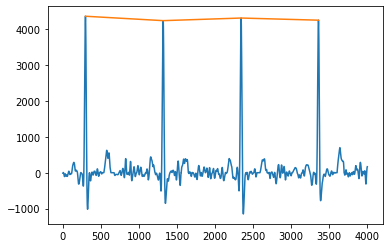

In [12]:
df = train
s_b = 0
s_len = 4000
s_ind = 0

cut_rpeaks = df["rpeaks"][s_ind][(df["rpeaks"][s_ind] <= s_len) & (df["rpeaks"][s_ind] >= s_b)]
plt.plot(range(s_b, s_len), df["ECG_F"][s_ind][s_b:s_len])
plt.plot(cut_rpeaks, [df["ECG_F"][s_ind][i] for i in cut_rpeaks])

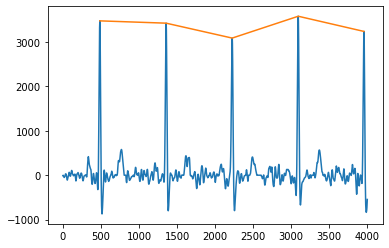

In [13]:
df = train
s_b = 0
s_len = 4000
s_ind = 1

cut_rpeaks = df["rpeaks"][s_ind][(df["rpeaks"][s_ind] <= s_len) & (df["rpeaks"][s_ind] >= s_b)]
plt.plot(range(s_b, s_len), df["ECG_F"][s_ind][s_b:s_len])
plt.plot(cut_rpeaks, [df["ECG_F"][s_ind][i] for i in cut_rpeaks])

In [14]:
def del_bad_signals(df):
    df = df.copy()
    df = df[df["lenrpeaks"] > 20].copy()
    df.reset_index(inplace=True, drop=True)
    return df

train = del_bad_signals(train)
test = del_bad_signals(test)
val = del_bad_signals(val)

In [15]:
print("ok")

ok


In [16]:
train["SignalLen"] = train["ECG_F"].apply(lambda x: len(x))
test["SignalLen"] = test["ECG_F"].apply(lambda x: len(x))
val["SignalLen"] = val["ECG_F"].apply(lambda x: len(x))

In [17]:
train.SignalLen.max()

100000

In [18]:
train.SignalLen.min()

30459

In [19]:
train.SignalLen.mean()

98591.32628859927

In [20]:
## Разбираемся с величиной пика

In [21]:
train["diff_r_peaks"] = train["rpeaks"].apply(lambda x: np.diff(x))
test["diff_r_peaks"] = test["rpeaks"].apply(lambda x: np.diff(x))
val["diff_r_peaks"] = val["rpeaks"].apply(lambda x: np.diff(x))

In [22]:
train["max_diff_r_peaks"] = train["diff_r_peaks"].apply(lambda x: np.max(x))
test["max_diff_r_peaks"] = test["diff_r_peaks"].apply(lambda x: np.max(x))
val["max_diff_r_peaks"] = val["diff_r_peaks"].apply(lambda x: np.max(x))

In [23]:
def count_signal_points(df):
    df = df.copy()
    df["num_bad_peaks"] = df["diff_r_peaks"].apply(lambda x: len(list(filter(lambda x: (x > 1400) or (x < 400), x))))
    return df
train = count_signal_points(train)
test = count_signal_points(test)
val = count_signal_points(val)

In [24]:
print(train["num_bad_peaks"].mean())
print(test["num_bad_peaks"].mean())
print(val["num_bad_peaks"].mean())

2.154397088176588
2.678172255095332
2.083306734759017


In [25]:
print(train["num_bad_peaks"].min())
print(test["num_bad_peaks"].min())
print(val["num_bad_peaks"].min())

0
0
0


In [26]:
print(train["num_bad_peaks"].max())
print(test["num_bad_peaks"].max())
print(val["num_bad_peaks"].max())

136
132
216


In [27]:
train["pr_bad_peaks"] = train["num_bad_peaks"] / train["lenrpeaks"]
test["pr_bad_peaks"] = test["num_bad_peaks"] / test["lenrpeaks"]
val["pr_bad_peaks"] = val["num_bad_peaks"] / val["lenrpeaks"]

In [28]:
print(train[train["pr_bad_peaks"] > 0.55].shape)
print(test[test["pr_bad_peaks"] > 0.55].shape)
print(val[val["pr_bad_peaks"] > 0.55].shape)

(17, 14)
(0, 14)
(0, 14)


In [29]:
def del_signals_with_bad_peaks(df):
    df = df.copy()
    df = df[df["pr_bad_peaks"] <= 0.55].copy()
    df.reset_index(inplace=True, drop=True)
    return df

In [30]:
train = del_signals_with_bad_peaks(train)
test = del_signals_with_bad_peaks(test)
val = del_signals_with_bad_peaks(val)

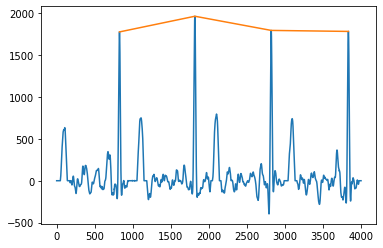

In [31]:
df = train
s_b = 0
s_len = 4000
s_ind = 1062

cut_rpeaks = df["rpeaks"][s_ind][(df["rpeaks"][s_ind] <= s_len) & (df["rpeaks"][s_ind] >= s_b)]
plt.plot(range(s_b, s_len), df["ECG_F"][s_ind][s_b:s_len])
plt.plot(cut_rpeaks, [df["ECG_F"][s_ind][i] for i in cut_rpeaks])

In [32]:
train["max_diff_r_peaks"].max()

55606

In [33]:
test["max_diff_r_peaks"].max()

33960

In [34]:
val["max_diff_r_peaks"].max()

33641

In [35]:
from scipy.signal import resample_poly

In [37]:
##Ресемплинг сигнала
train["ECG_R"] = train.ECG_F.apply(lambda x: resample_poly(x, 1, 5)) 
test["ECG_R"] = test.ECG_F.apply(lambda x: resample_poly(x, 1, 5))
val["ECG_R"] = val.ECG_F.apply(lambda x: resample_poly(x, 1, 5))

In [38]:
train["RSignalLen"] = train["ECG_R"].apply(lambda x: len(x))
test["RSignalLen"] = test["ECG_R"].apply(lambda x: len(x))
val["RSignalLen"] = val["ECG_R"].apply(lambda x: len(x))

In [39]:
train.RSignalLen.max()

20000

In [40]:
##Нормализация сигналов

In [41]:
def norm_signal(x):
    return (x - x.min()) / (x.max() - x.min()) * 2 - 1

In [42]:
#train["ECG_N"] = train.ECG_F.apply(lambda x: norm_signal(x)) 
#test["ECG_N"] = test.ECG_F.apply(lambda x: norm_signal(x))
#val["ECG_N"] = val.ECG_F.apply(lambda x: norm_signal(x))

In [43]:
train["RECG_N"] = train.ECG_R.apply(lambda x: norm_signal(x)) 
test["RECG_N"] = test.ECG_R.apply(lambda x: norm_signal(x))
val["RECG_N"] = val.ECG_R.apply(lambda x: norm_signal(x))

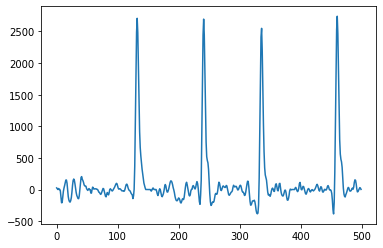

In [44]:
df = train
s_b = 0
s_len = 500
s_ind = 200

cut_rpeaks = df["rpeaks"][s_ind][(df["rpeaks"][s_ind] <= s_len) & (df["rpeaks"][s_ind] >= s_b)]
plt.plot(range(s_b, s_len), df["ECG_R"][s_ind][s_b:s_len])
#plt.plot(cut_rpeaks, [df["ECG_R"][s_ind][i] for i in cut_rpeaks])

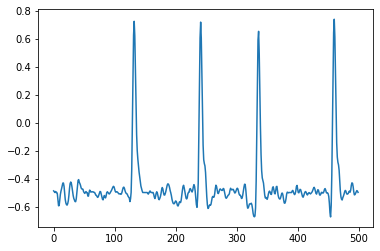

In [45]:
df = train
s_b = 0
s_len = 500
s_ind = 200

cut_rpeaks = df["rpeaks"][s_ind][(df["rpeaks"][s_ind] <= s_len) & (df["rpeaks"][s_ind] >= s_b)]
plt.plot(range(s_b, s_len), df["RECG_N"][s_ind][s_b:s_len])
#plt.plot(cut_rpeaks, [df["RECG_N"][s_ind][i] for i in cut_rpeaks])

In [46]:
#mean = train["ECG_F"].mean()
#std = train["ECG_F"].std()

In [47]:
##Доступные размеры картинок для подачи в ResNext
## Любой квадратный размер

In [48]:
## Преобразование данных (возможное разделение на более короткие сигналы)

In [49]:
#peaks_number - максимальное число пиков, определяется на основе доступных размеров ResNext

def create_df_rpeak(signal, peaks_number):
    
    pass

def create_image_rpeak(signal, peaks_number):
    pass

In [100]:
def create_signal_image(signal, n_rows= 75, n_points = 4000, dpi=64, figsize=(17,17), slice_size=1000):
    fig, ax = plt.subplots(nrows=n_rows, dpi=dpi,figsize=figsize )
    for k in range(n_rows):
        ax[k].axis('off')
        ax[k].plot(signal[n_points * k:n_points * (k+1)])
    fig.tight_layout()
    fig.canvas.draw()
    
    X = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    return X

In [93]:
20000 / 7

2857.1428571428573

In [94]:
ind = 0
train["RECG_N"][ind].shape

(20000,)

In [95]:

X = create_signal_image(train["RECG_N"][ind], n_rows = 7, n_points=2857, dpi=70)

In [96]:
X.shape

(770, 770, 4)

In [97]:
import cv2

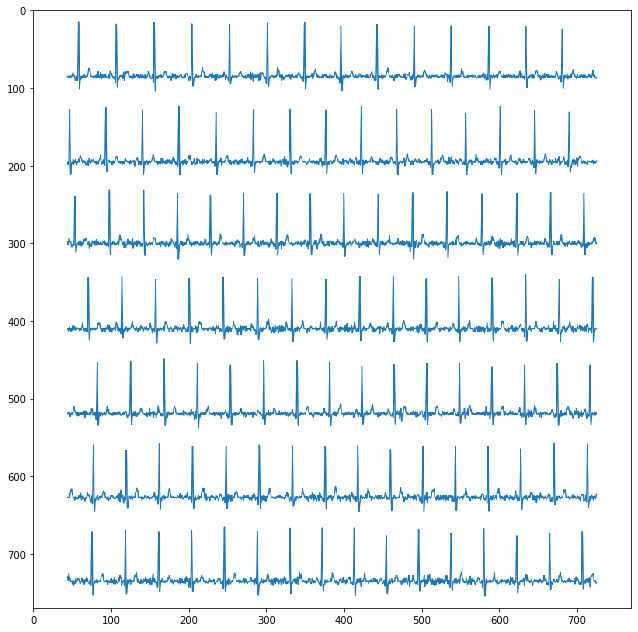

In [99]:
plt.figure(figsize=(11,11))
plt.imshow(X)

In [56]:
train["index"] = train.index
test["index"] = test.index
val["index"] = val.index

In [57]:
train["label"] = train.disease_info
test["label"] = test.disease_info
val["label"] = val.disease_info

In [58]:
train["path"] = train["index"].apply(lambda x: "train_tb_images"+"/"+str(x))
test["path"] = test["index"].apply(lambda x: "test_tb_images"+"/"+str(x))
val["path"] = val["index"].apply(lambda x: "val_tb_images"+"/"+str(x))

In [59]:
train[['index', 'label', 'path', 'RSignalLen', 'cardiogram_id', 'disease_info', 'patient_id']].to_csv("image_train.csv", index=False)
test[['index', 'label', 'path', 'RSignalLen', 'cardiogram_id', 'disease_info', 'patient_id']].to_csv("image_test.csv", index=False)
val[['index', 'label', 'path', 'RSignalLen', 'cardiogram_id', 'disease_info', 'patient_id']].to_csv("image_val.csv", index=False)




In [60]:
print("ok")

ok


In [70]:
!mkdir val_tb_images

In [ ]:
def create_and_save_image(image, signal_id, path):
    x = create_signal_image(image, n_rows = 13, n_points=1539, dpi=70)
    with open(path+"/"+str(signal_id)+".npy", "wb") as f:
        np.save(f, x)
    del x

In [67]:
def create_image_mp(x):
    create_and_save_image(x[0], x[1], "train_tb_images")

with mp.Pool(20) as mp_pool:
    mp_pool.map(create_image_mp, zip(train["RECG_N"].values[6000:], train["index"].values[6000:]))

In [68]:
def create_image_mp(x):
    create_and_save_image(x[0], x[1], "test_tb_images")

with mp.Pool(20) as mp_pool:
    mp_pool.map(create_image_mp, zip(test["RECG_N"].values, test["index"].values))

In [71]:
def create_image_mp(x):
    create_and_save_image(x[0], x[1], "val_tb_images")

with mp.Pool(20) as mp_pool:
    mp_pool.map(create_image_mp, zip(val["RECG_N"].values, val["index"].values))

In [ ]:
!mkdir

In [ ]:
def create_and_save_image2(image, signal_id, path):
    x = create_signal_image(image, n_rows = 7, n_points=2857, dpi=70, figesize=(11, 11))
    with open(path+"/"+str(signal_id)+".npy", "wb") as f:
        np.save(f, x)
    del x

In [ ]:
def resample(x):
    return resample_poly(x, 1, 90)

In [83]:
#for i, ind in tqdm(zip(train["RECG_N"].values, train["index"].values)):
#    create_and_save_image(i, ind, "train_tb_images")

In [ ]:
[create_and_save_image(i, ind, "train_tb_images") for i, ind in zip(train["RECG_N"], train["index"])]
[create_and_save_image(i, ind, "test_tb_images") for i, ind in zip(test["RECG_N"], test["index"])]
[create_and_save_image(i, ind, "val_tb_images") for i, ind in zip(val["RECG_N"], val["index"])]

In [ ]:
train.to_cs

In [ ]:
#train_images = [create_signal_image(i, n_rows = 13, n_points=1539, dpi=70) for i in train["RECG_N"]]
#val_images = [create_signal_image(i, n_rows = 13, n_points=1539, dpi=70) for i in val["RECG_N"]]
#test_images = [create_signal_image(i, n_rows = 13, n_points=1539, dpi=70) for i in test["RECG_N"]]

In [ ]:
##Ресемплинг данных

In [ ]:
## Обучение нейронной сети с предобученными весами

In [ ]:
## Обучение нейронной сети без предобученных весов

In [ ]:
## Оценка качества

In [ ]:
## Интерпретация данных